# HDC model training notebook 

Steps:
- load raw data 
- generate configs (hyper parameter)
- do cross validation to find the best configs (hyper parameters)
- train the model with the best hyperparameters in entire data from cross validation step 
- evaluate the model with test data (not included in cross validation train/val set)
- save the model and result

Note:
in this notebook, the final performance of the model is evaluated with test data.


In [1]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu


In [2]:
MODEL_NAME='HDC_LIGHTGBM_FORREAL'

In [3]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from tqdm import tqdm
from scipy import stats
from scipy.special import softmax
import random
import builtins
import torch
import torch.nn as nn
import torch.nn.functional as F
#Use local Executorch compatible copy of TorchHD
import os
sys.path.insert(0, os.path.abspath("../../../torchhd"))
sys.path.insert(0, os.path.abspath("../../../torchhd/torchhd"))
import torchhd
from torchhd import embeddings
from torchhd import models
print(torchhd.__file__) #Check
print(embeddings.__file__) #Check
print(models.__file__) #Check
from typing import Union, Literal
import json 
import pickle
# import torchmetrics
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.metrics import (
    mean_squared_error,
    median_absolute_error,
    r2_score,
    average_precision_score,
)
import warnings
from sklearn.preprocessing import StandardScaler
import gc
import time
from datetime import datetime
import logging
from tqdm import tqdm
from IPython.display import display
import os
from glob import glob
import polars as pl 
warnings.filterwarnings("ignore")


random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd/__init__.py
/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd/embeddings.py
/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd/models.py


In [4]:
import sys, os

# Remove torchhd if already loaded
if "torchhd" in sys.modules:
    del sys.modules["torchhd"]

# Point to the actual package folder (the one with __init__.py)
sys.path.insert(0, os.path.abspath("/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd"))

# Now import
import torchhd
from torchhd import embeddings, models

# Sanity check
print(torchhd.__file__)
assert hasattr(models.Centroid, "add_adjust"), "Custom torchhd still not loaded correctly"


/Users/jofremosegui/Desktop/TFG/wearbac_experiments/torchhd/torchhd/__init__.py


In [5]:
hasattr(models.Centroid, "add_adjust")

True

In [6]:
RAW_COLUMNS = ['user_id', 'ZTIME', 'ZVALUEX_acc', 'ZVALUEY_acc', 
               'ZVALUEZ_acc', 'ZVALUEX_gyro', 'ZVALUEY_gyro', 'ZVALUEZ_gyro', 'ZHEARTRATE', 'ZAVERAGEHEARTRATE', 
              'tac (ug/L)', 'tac_flg', 'session_id']

TAC_THRESHOLD = 35
TAC_LEVEL_0 = 0
TAC_LEVEL_1 = 1
NUM_TAC_LEVELS = 2

ALL_USERS = [ 6,  9, 10, 11, 14, 15, 16, 24, 25, 26, 28, 31]

TRAIN_USERS = [[9, 10, 14, 15, 24, 28, 31],
[10, 11, 6, 31],
[6, 9, 11, 14, 15, 24, 28]]


VALID_USERS = [[11, 6],
[9, 14, 15, 24, 28],
[10, 31]]

TEST_USERS = [16,25,26]

# base config 
BASE_CONFIGS = {
    "device": "mps" if torch.backends.mps.is_available() else "cpu",
    "window_size": [40*20],
    "ngrams": [7],
    "hdc_dimension": 5000,
    "batch_size": [64],
    "learning_rate": [2],
    "epochs": 10,
    "patience": 5, # early stopping
    "overlap_ratio": 0.5,
}

In [7]:
### ADDED TWEAKS
def add_noise(seq, level=0.01):
    return seq + np.random.normal(0, level, seq.shape)

def drift_signal(seq, max_shift=0.1):
    drift = np.random.uniform(-max_shift, max_shift, (1, seq.shape[1]))
    return seq + drift
def time_shift(seq, max_shift=5):
    shift = np.random.randint(-max_shift, max_shift)
    return np.roll(seq, shift, axis=0)
def mixup(seq1, seq2, alpha=0.3):
    return alpha * seq1 + (1 - alpha) * seq2


In [8]:
def load_data(preprocess_fld='../../Preprocessed_all'):
    file_paths = sorted(glob(preprocess_fld + '/after_preprocess_group*.csv'))
    df_final = [pl.read_csv(file_path, columns=RAW_COLUMNS) for file_path in file_paths]
    columns = df_final[-1].columns
    df_final = pl.concat([data_df[columns] for data_df in df_final])
    df_final = df_final.filter(df_final['user_id'].is_in(ALL_USERS))

    # Rebuild session_id
    df_final = (
        df_final.with_columns([
            pl.concat_str([
                pl.col('user_id').cast(pl.Utf8),
                pl.lit('_'),
                pl.col('session_id')
            ]).alias('combined_key')
        ])
        .with_columns([
            pl.col('combined_key').rank(method='dense').cast(pl.Int32).alias('session_id')
        ])
        .drop('combined_key')
    )

    # # Fix: invert labels – 1 = sober → 0, 0 = drunk → 1
    # df_final = df_final.with_columns(
    #     pl.col('tac_flg').cast(float).map_elements(lambda x: 1.0 - x).alias('tac_flg')
    # )

    return df_final.to_pandas()


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score

def extract_hdc_embeddings(encoder, sequences, batch_size=128, device="cpu"):
    encoder.eval()
    all_hvs = []

    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            batch = torch.tensor(sequences[i:i+batch_size], dtype=torch.float32).to(device)
            hvs = encoder(batch)
            all_hvs.append(hvs.cpu().numpy())

    return np.concatenate(all_hvs, axis=0)


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
class TimeSeriesDataset(Dataset):
    def __init__(self, features, labels, window_size=10):
        self.features = features
        self.labels = labels
        self.window_size = window_size

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (
            torch.FloatTensor(self.features[idx]),
            torch.FloatTensor([self.labels[idx]]),
        )

class HdcGenericEncoder(torch.nn.Module):
    def __init__(self, input_size: int, out_dimension: int, ngrams: int = 5, dtype=torch.float32, device="cpu"):
        super(HdcGenericEncoder, self).__init__()

        self.cpu_device = torch.device("cpu")  # Force CPU for all TorchHD ops

        self.input_size = input_size
        self.ngrams = ngrams
        self.dtype = dtype
        self.device = device  # final model output device (e.g., mps or cpu)

        self.keys = embeddings.Random(input_size, out_dimension, dtype=dtype, device=self.cpu_device)
        self.motion_embed = embeddings.Level(3000, out_dimension, low=-3.0, high=3.0, dtype=dtype, device=self.cpu_device)
        self.hr_embed = embeddings.Level(200, out_dimension, low=50, high=200, dtype=dtype, device=self.cpu_device)

    def batch_generic(self, id, levels, ngram):
        batch_size = levels.shape[0]
        multiset_list = []
        for b in range(batch_size):
            level = levels[b]
            b_levels = [
                torchhd.ngrams(level[0][i : i + ngram], ngram)
                for i in range(1, id.shape[0] - ngram + 1)
            ]
            if len(b_levels) > 0:
                b_levels = torch.stack(b_levels)
                multiset_list.append(torchhd.multiset(torchhd.bind(id[:-ngram], b_levels)).unsqueeze(0))
            else:
                multiset_list.append(torchhd.multiset(torchhd.bind(id, level)))
        return torch.stack(multiset_list)

    def forward(self, channels: torch.Tensor) -> torch.Tensor:
        # Move input to CPU
        channels = channels.to(self.cpu_device)

        motion = channels[:, :, : self.input_size - 1]
        hr = channels[:, :, self.input_size - 1].unsqueeze(-1)

        motion_hv = self.motion_embed(motion)
        hr_hv = self.hr_embed(hr)
        combined = torch.cat([motion_hv, hr_hv], dim=2)

        hvs = self.batch_generic(self.keys.weight, combined, self.ngrams)
        sample = torchhd.multiset(hvs)
        sample = torchhd.hard_quantize(sample)

        return sample.to(self.device)  # Return tensor back to main device (e.g., MPS)


    
    
class HdcModel(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        out_dimension: int,
        ngrams: int = 5,
        dtype=torch.float32,
        device: str = "cpu",
    ):
        super(HdcModel, self).__init__()
        
        self.encoder = HdcGenericEncoder(input_size, out_dimension, ngrams=ngrams, dtype=dtype, device=device)
        self.centroid = models.Centroid(
                out_dimension,
                NUM_TAC_LEVELS,
                dtype=dtype,
                device=device,
            )
        self.device = device
        self.dtype = dtype

    def add(self, x : torch.Tensor, y : torch.Tensor, lr : float):
        hv = self.encoder(x)
        labels = y.to(dtype=torch.int64)
        for i in range(len(hv)):
            #This operations can't be done in batches
            self.centroid.add_adjust(
                    hv[i].unsqueeze(0), labels[i], lr=lr
                )
            
    def adjust_reset(self):
        self.centroid.adjust_reset()
        
    #Executorch safe (0.6.x)
    def vector_norm(self, x, p=2, dim=None, keepdim=False):
        return torch.pow(torch.sum(torch.abs(x) ** p, dim=dim, keepdim=keepdim), 1 / p)
        
    def normalized_inference(self, input: torch.Tensor, dot: bool = False):
        normalized_weight = self.centroid.weight.detach().clone()
        norms = self.vector_norm(normalized_weight, p=2, dim=1, keepdim=True)
        norms.clamp_(min=1e-12)
        normalized_weight.div_(norms)

        if dot:
            return torchhd.functional.dot_similarity(input, normalized_weight)
        return torchhd.functional.cosine_similarity(input, normalized_weight)
        
    def binary_hdc_output(self, outputs):
        probs = F.softmax(outputs, dim=1)  # Shape: (batch_size, 2)
        return probs[:, 1]  # Extract only class 1 probability
        
    def forward(self, x : torch.Tensor):
        hv = self.encoder(x)
        output = self.normalized_inference(hv, True)

        return self.binary_hdc_output(output)

from sklearn.utils import resample

def prepare_sequences_undersampled(df, window_size=10, overlap_ratio=0.1, feature_columns=None):
    """
    Generate sequences and apply undersampling to balance class distribution.
    """
    session_user_map = pd.Series(df["user_id"].values, index=df["session_id"]).astype(int).to_dict()
    if feature_columns is None:
        feature_columns = [
            "ZVALUEX_acc",
            "ZVALUEY_acc",
            "ZVALUEZ_acc",
            "ZVALUEX_gyro",
            "ZVALUEY_gyro",
            "ZVALUEZ_gyro",
            "ZHEARTRATE",
        ]

    print(f"Preparing sequences with undersampling...")

    features = df[feature_columns].values
    labels = df["tac_flg"].values
    session_ids = df["session_id"].values
    unique_sessions = np.unique(session_ids)

    sequences = []
    sequence_labels = []
    sequence_user_ids = []

    for session_id in tqdm(unique_sessions):
        session_mask = session_ids == session_id
        session_indices = np.where(session_mask)[0]

        if len(session_indices) >= window_size:
            for start_idx in range(0, len(session_indices) - window_size + 1, int(window_size * overlap_ratio)):
                window_indices = session_indices[start_idx : start_idx + window_size]
                if len(window_indices) < window_size:
                    continue

                sequence = features[window_indices]
                label = int(stats.mode(labels[window_indices].astype(int), keepdims=False).mode)

                sequences.append(sequence)
                sequence_labels.append(label)
                sequence_user_ids.append(session_user_map[session_id])

    sequences = np.array(sequences)
    sequence_labels = np.array(sequence_labels)
    sequence_user_ids = np.array(sequence_user_ids)

    # === Undersample the majority class (label == 1)
    print("Balancing sequences via undersampling...")

    sober_mask = sequence_labels == 1
    drunk_mask = sequence_labels == 0

    sober_seqs = sequences[sober_mask]
    sober_labels = sequence_labels[sober_mask]
    sober_users = sequence_user_ids[sober_mask]

    drunk_seqs = sequences[drunk_mask]
    def augment_drunk(seqs, labels, users, n_aug=1):
        new_seqs, new_labels, new_users = [], [], []
        for i in range(len(seqs)):
            for _ in range(n_aug):
                aug_seq = add_noise(seqs[i], level=0.01)
                new_seqs.append(aug_seq)
                new_labels.append(labels[i])
                new_users.append(users[i])
        return (
            np.concatenate([seqs, np.stack(new_seqs)]),
            np.concatenate([labels, new_labels]),
            np.concatenate([users, new_users]),
        )

    
    drunk_labels = sequence_labels[drunk_mask]
    drunk_users = sequence_user_ids[drunk_mask]
    
    drunk_seqs, drunk_labels, drunk_users = augment_drunk(drunk_seqs, drunk_labels, drunk_users, n_aug=1)
    if len(drunk_seqs) == 0 or len(sober_seqs) == 0:
        raise ValueError("Insufficient class samples for undersampling.")

    undersample_ratio = 1  # or test 1.2, 1.3...
    n_samples = min(len(sober_seqs), int(len(drunk_seqs) * undersample_ratio))


    from sklearn.model_selection import StratifiedShuffleSplit

    if len(sober_seqs) > n_samples:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=(len(sober_seqs) - n_samples), random_state=42)
        idxs_to_keep, _ = next(sss.split(sober_seqs, sober_users))
        sober_seqs_resampled = sober_seqs[idxs_to_keep]
        sober_labels_resampled = sober_labels[idxs_to_keep]
        sober_users_resampled = sober_users[idxs_to_keep]
    else:
        # Not enough to subsample, just keep all
        sober_seqs_resampled = sober_seqs
        sober_labels_resampled = sober_labels
        sober_users_resampled = sober_users



    # Combine and shuffle
    sequences_balanced = np.concatenate([sober_seqs_resampled, drunk_seqs])
    labels_balanced = np.concatenate([sober_labels_resampled, drunk_labels])
    users_balanced = np.concatenate([sober_users_resampled, drunk_users])

    indices = np.arange(len(labels_balanced))
    np.random.shuffle(indices)

    sequences_balanced = sequences_balanced[indices]
    labels_balanced = labels_balanced[indices]
    users_balanced = users_balanced[indices]

    print(f"Undersampled sequence shape: {sequences_balanced.shape}")

    return sequences_balanced, labels_balanced, users_balanced

def prepare_sequences_fast(df, window_size=10, overlap_ratio=0.1, feature_columns=None):
        session_user_map = pd.Series(df["user_id"].values, index=df["session_id"]).astype(int).to_dict()
        if feature_columns is None:
            feature_columns = [
                "ZVALUEX_acc",
                "ZVALUEY_acc",
                "ZVALUEZ_acc",
                "ZVALUEX_gyro",
                "ZVALUEY_gyro",
                "ZVALUEZ_gyro",
                "ZHEARTRATE",
            ]

        print(f"Starting sequence preparation...")

        # 特徴量とラベルを事前にNumPy配列に変換
        features = df[feature_columns].values
        labels = df["tac_flg"].values
        session_ids = df["session_id"].values

        # セッションのユニークなIDと各セッションのインデックスを取得
        unique_sessions = np.unique(session_ids)
        print(f"Processing {len(unique_sessions)} sessions...")

        sequences = []
        sequence_labels = []
        sequence_user_ids = []

        for session_id in tqdm(unique_sessions):
            session_mask = session_ids == session_id
            session_indices = np.where(session_mask)[0]

            if len(session_indices) >= window_size:
                for start_idx in range(
                    0, len(session_indices) - window_size + 1, np.ceil(window_size*overlap_ratio).astype(int)
                ):
                    window_indices = session_indices[start_idx : start_idx + window_size]
                    if len(window_indices) < window_size:
                        continue

                    sequence = features[window_indices]
                    # get the mode label in the current window
                    label = stats.mode(labels[window_indices].astype(int))[0]

                    sequences.append(sequence)
                    sequence_labels.append(label)
                    sequence_user_ids.append(session_user_map[session_id])

        sequences = np.array(sequences)
        sequence_labels = np.array(sequence_labels)

        print(f"Created {len(sequences)} sequences")
        print(f"Sequences shape: {sequences.shape}")

        return sequences, sequence_labels, sequence_user_ids


def validate_model(model, valid_loader, criterion, device):
    """検証データでのモデル評価"""
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.squeeze(-1))
            val_loss += loss.item()

            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(batch_y.squeeze(-1).cpu().numpy())

    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)

    val_prauc = average_precision_score(val_labels, val_preds)
    val_rocauc = roc_auc_score(val_labels, val_preds)

    return {
        "loss": val_loss / len(valid_loader),
        "pr_auc": val_prauc,
        "roc_auc": val_rocauc,
    }


def train_model(
    model : HdcModel,
    train_loader,
    valid_loader,
    criterion,
    lr,
    device,
    epochs=100,
    patience=5,
):
    best_val_prauc = 0
    patience_counter = 0
    best_train_epoch = 0
    best_model_state = None
    training_history = []

    print(
        "Epoch | Train Loss |  Val Loss  |  Val PR-AUC  |  Val ROC-AUC  |  Epoch Time (s)"
    )
    print("-" * 85)

    for epoch in range(epochs):
        start_time = time.time()

        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            model.add(batch_X, batch_y, lr)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.squeeze(-1))

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        epoch_time = time.time() - start_time
        
        model.adjust_reset()

        if valid_loader is None:
            epoch_results = {"epoch": epoch + 1, "train_loss": train_loss, "time": epoch_time}
            training_history.append(epoch_results)
            print(f"{epoch+1:5d} | {train_loss:.6f} | ------ | ------ | {epoch_time:.2f}")
            continue
    
        val_metrics = validate_model(model, valid_loader, criterion, device)
        epoch_results = {"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_metrics["loss"], 
                         "val_pr_auc": val_metrics["pr_auc"], "val_roc_auc": val_metrics["roc_auc"], "time": epoch_time}
        training_history.append(epoch_results)

        print(
            f"{epoch+1:5d} | {train_loss:.6f} | {val_metrics['loss']:.6f} | "
            f"{val_metrics['pr_auc']:.4f} | {val_metrics['roc_auc']:.4f} | "
            f"{epoch_time:.2f}"
        )
        
        if val_metrics["pr_auc"] >= best_val_prauc:
            best_val_prauc = val_metrics["pr_auc"]
            best_model_state = model.state_dict()
            patience_counter = 0
            best_train_epoch = epoch
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after epoch {epoch+1}")
            print(f"Best validation PR-AUC: {best_val_prauc:.4f}")
            break

    if best_model_state is not None: 
        model.load_state_dict(best_model_state)
    return model, training_history, best_train_epoch


def inference_dataset(model, data_loader, device, pred_threshold=None):
    """evaluation model after a fold training"""
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            outputs = model(batch_X)
            predictions.extend(outputs.cpu().numpy())
            labels.extend(batch_y.squeeze(-1).cpu().numpy())

    pred_prob = np.array(predictions)
    gt_labels = np.array(labels)
    return pred_prob, gt_labels


def performance_calculation(pred_prob, gt_label, threshold=None):
    '''
    Calculate the performance of the model
    Args:
    pred_prob: list, predicted probability
    gt_label: list, ground truth label
    threshold: float, threshold for binary classification (None if we are evaluating on train data)
    '''
    if threshold is None:
        # Find the optimal threshold by maximizing F1 score
        thresholds = np.linspace(0.01, 0.99, 99)  # Test 99 threshold values
        best_f1 = 0
        best_threshold = 0.5  # Default if no better threshold is found
        
        for t in thresholds:
            temp_pred = (pred_prob >= t).astype(int)
            temp_f1 = (f1_score(gt_label, temp_pred, pos_label=0) + f1_score(gt_label, temp_pred, pos_label=1)) / 2

            
            if temp_f1 > best_f1:
                best_f1 = temp_f1
                best_threshold = t
        
        threshold = best_threshold
        
    pred_label = (pred_prob >= threshold).astype(int)
    roc_auc = roc_auc_score(gt_label, pred_prob)
    pr_auc = average_precision_score(gt_label, pred_prob)
    accuracy = accuracy_score(gt_label, pred_label)

    # Since 0 = drunk and 1 = sober
    drunk_acc = accuracy_score(gt_label[gt_label == 0], pred_label[gt_label == 0])
    sober_acc = accuracy_score(gt_label[gt_label == 1], pred_label[gt_label == 1])

    f1 = f1_score(gt_label, pred_label)
    return roc_auc, pr_auc, accuracy, sober_acc, drunk_acc, f1, threshold


def generate_configs(base_config):
    """
    Generate multiple configurations from a base config.
    For any list values in the base config, create a separate config for each list item.
    
    Args:
        base_config (dict): Base configuration with potential list values
        
    Returns:
        list: List of individual configurations
    """
    # Find all keys with list values
    list_keys = [key for key, value in base_config.items() if isinstance(value, list)]
    
    if not list_keys:
        # If no list values found, return the original config
        return [base_config]
    
    # Start with the first list key
    key = list_keys[0]
    values = base_config[key]
    
    # Generate configurations for each value of the first list key
    configs = []
    for value in values:
        # Create a new config with this specific value
        new_config = base_config.copy()
        new_config[key] = value
        
        # Recursively handle any remaining list keys
        remaining_configs = generate_configs(new_config)
        configs.extend(remaining_configs)
    
    return configs

def train_rf_classifier():
    df = load_data()
    device = "mps" if torch.backends.mps.is_available() else "cpu"

    # Normalize data
    feature_cols = ["ZVALUEX_acc", "ZVALUEY_acc", "ZVALUEZ_acc", "ZVALUEX_gyro", "ZVALUEY_gyro", "ZVALUEZ_gyro"]
    scaler = StandardScaler()
    df[feature_cols] = scaler.fit_transform(df[feature_cols])

    # Prepare sequences
    window_size = 800
    overlap_ratio = 0.5
    X_train, y_train, _ = prepare_sequences_undersampled(df[df["user_id"].isin(TRAIN_USERS[0] + VALID_USERS[0])], window_size, overlap_ratio)
    X_test, y_test, _ = prepare_sequences_fast(df[df["user_id"].isin(TEST_USERS)], window_size, overlap_ratio)

    print("Encoding with HDC encoder...")
    encoder = HdcGenericEncoder(input_size=X_train.shape[2], out_dimension=5000, ngrams=7, device=device)
    encoder.to(device)

    X_train_hdc = extract_hdc_embeddings(encoder, X_train, device=device)
    X_test_hdc = extract_hdc_embeddings(encoder, X_test, device=device)

    print(f"HDC Train shape: {X_train_hdc.shape}, Test shape: {X_test_hdc.shape}")

    print("Training Random Forest...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_hdc, y_train)

    preds = clf.predict(X_test_hdc)
    proba = clf.predict_proba(X_test_hdc)[:, 1]

    print("Evaluation:")
    print(classification_report(y_test, preds))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, preds))
    print(f"ROC AUC: {roc_auc_score(y_test, proba):.4f}")
    print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
    print(f"F1 Score: {f1_score(y_test, preds):.4f}")


In [11]:
def save_model_and_results(model, save_folder, train_preds, train_gt_labels, test_preds, test_gt_labels, metrics, config):
    """
    Save model, predictions, ground truth, metrics, and model structure to the specified folder.
    
    Args:
        model: The trained model
        save_folder: Folder path to save results
        train_preds: Training predictions
        train_gt_labels: Training ground truth labels
        test_preds: Test predictions
        test_gt_labels: Test ground truth labels
        metrics: Dictionary containing evaluation metrics
        config: Model configuration dictionary
    """
    # Create a timestamp for the save files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save the model
    model_path = os.path.join(save_folder, f"model_{timestamp}.pt")
    torch.save(model.state_dict(), model_path)
    
    # Save model architecture as text
    model_structure_path = os.path.join(save_folder, f"model_structure_{timestamp}.txt")
    with open(model_structure_path, 'w') as f:
        f.write(str(model))
    
    # Save predictions and ground truth
    predictions_data = {
        'train_predictions': train_preds.tolist() if isinstance(train_preds, np.ndarray) else train_preds,
        'train_ground_truth': train_gt_labels.tolist() if isinstance(train_gt_labels, np.ndarray) else train_gt_labels,
        'test_predictions': test_preds.tolist() if isinstance(test_preds, np.ndarray) else test_preds,
        'test_ground_truth': test_gt_labels.tolist() if isinstance(test_gt_labels, np.ndarray) else test_gt_labels
    }
    pred_path = os.path.join(save_folder, f"predictions_{timestamp}.pkl")
    with open(pred_path, 'wb') as f:
        pickle.dump(predictions_data, f)
    
    # Save all metrics
    metrics_path = os.path.join(save_folder, f"metrics_{timestamp}.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Save the configuration
    config_path = os.path.join(save_folder, f"config_{timestamp}.json")
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    
    print(f"Model, predictions, ground truth, and metrics saved in {save_folder}")


def train_and_eval_final_model(best_config, best_threshold, df):
    print('\nBEGIN TRAIN AND EVALUATION FINAL MODEL\n')
    feature_columns = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        "ZHEARTRATE",
    ]

    # Hyper parameter loading
    device = best_config['device'] 
    window_size = best_config['window_size']
    input_size = len(feature_columns)
    batch_size = best_config['batch_size']
    hdc_dimension = best_config['hdc_dimension']
    ngrams = best_config['ngrams']
    learning_rate = best_config['learning_rate']
    epochs = best_config['epochs']
    patience = best_config['patience']
    runtime_log_fld = best_config['runtime_log_fld']
    overlap_ratio = best_config['overlap_ratio']
    
    train_user = list(set(ALL_USERS)- set(TEST_USERS))
    test_user = TEST_USERS
        
    train_data = df[df['user_id'].isin(train_user)]
    test_data = df[df['user_id'].isin(test_user)]
    # columns will be normalized
    columns_to_standardize = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        #'ZHEARTRATE'
    ]

    # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
    scaler = StandardScaler()
    train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
    test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

    print("Preparing sequences...")
    X_train, y_train, train_user_ids = prepare_sequences_undersampled(train_data, window_size, overlap_ratio)
    X_test, y_test, test_user_ids = prepare_sequences_fast(test_data, window_size, overlap_ratio)


    print(f"Users in train:{set(train_data['user_id'])}")
    print(f"Users in test:{set(test_data['user_id'])}")
    print(f"Number of windows for training:{len(X_train)}")
    print(f"Number of windows for testing:{len(X_test)}")

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = HdcModel(input_size, hdc_dimension, ngrams, device=device)

    criterion = nn.BCELoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 02. Train model (set patience to ensure that the model is trained for the best epoch)
    model, training_history, _ = train_model(
        model=model, train_loader=train_loader, valid_loader=None, 
        criterion=criterion, lr=learning_rate, device=device, epochs=epochs
    )

    # 03. Inference
    train_preds, train_gt_labels = inference_dataset(model, train_loader, device)
    test_preds, test_gt_labels = inference_dataset(model, test_loader, device)

    # 04. Calculate performance of current config: ROC, PR-AUC, ACC, F1, Drunk ACC, Sober ACC
    train_roc_auc, train_pr_auc, train_accuracy, train_sober_acc, train_drunk_acc, train_f1, train_threshold = performance_calculation(train_preds, train_gt_labels, threshold=best_threshold)
    print(f"Training ROC-AUC: {train_roc_auc:.4f}, PR-AUC: {train_pr_auc:.4f}, Accuracy: {train_accuracy:.4f}, Sober Accuracy: {train_sober_acc:.4f}, Drunk Accuracy: {train_drunk_acc:.4f}, F1: {train_f1:.4f}, Threshold: {train_threshold:.4f}")
    test_roc_auc, test_pr_auc, test_accuracy, test_sober_acc, test_drunk_acc, test_f1, test_threshold = performance_calculation(test_preds, test_gt_labels, threshold=best_threshold)
    print(f"Test ROC-AUC: {test_roc_auc:.4f}, PR-AUC: {test_pr_auc:.4f}, Accuracy: {test_accuracy:.4f}, Sober Accuracy: {test_sober_acc:.4f}, Drunk Accuracy: {test_drunk_acc:.4f}, F1: {test_f1:.4f}, Threshold: {test_threshold:.4f}")    

    # 05. Save model, predictions, ground truth, metrics and model structure
    metrics = {
        'train': {
            'roc_auc': train_roc_auc,
            'pr_auc': train_pr_auc,
            'accuracy': train_accuracy,
            'sober_accuracy': train_sober_acc,
            'drunk_accuracy': train_drunk_acc,
            'f1': train_f1,
            'threshold': train_threshold
        },
        'test': {
            'roc_auc': test_roc_auc,
            'pr_auc': test_pr_auc,
            'accuracy': test_accuracy,
            'sober_accuracy': test_sober_acc,
            'drunk_accuracy': test_drunk_acc,
            'f1': test_f1,
            'threshold': test_threshold
        },
        'config': best_config
    }
    
    # Call the function to save all results
    save_model_and_results(
        model=model,
        save_folder=runtime_log_fld,
        train_preds=train_preds,
        train_gt_labels=train_gt_labels,
        test_preds=test_preds,
        test_gt_labels=test_gt_labels,
        metrics=metrics,
        config=best_config
    )
    
    # refresh GPU
    model.to("cpu")
    del model
    gc.collect()
    
    return train_accuracy, test_accuracy, metrics

def train_cross_validation(df, all_configs):
    print("="*50 + "\nBEGIN CROSSVALIDATION\n" + "="*50)    
    best_config = None 
    best_pr_auc = 0
    best_threshold = 0.5 
    for config_idx, config in enumerate(all_configs):
        print(f"\nCONFIG {config_idx}: {config}\n")
        feature_columns = [
            "ZVALUEX_acc",
            "ZVALUEY_acc",
            "ZVALUEZ_acc",
            "ZVALUEX_gyro",
            "ZVALUEY_gyro",
            "ZVALUEZ_gyro",
            "ZHEARTRATE",
        ]

        # Hyper parameter loading
        device = config['device'] 
        window_size = config['window_size']
        input_size = len(feature_columns)
        batch_size = config['batch_size']
        hdc_dimension = config['hdc_dimension']
        ngrams = config['ngrams']
        learning_rate = config['learning_rate']
        epochs = config['epochs']
        overlap_ratio = config['overlap_ratio']
        patience = config['patience']

        # variables for temperary storing
        val_all_preds = []
        val_all_gt_labels = []
        val_trained_epoch = []

        for fold, (train_user, val_user) in enumerate(zip(TRAIN_USERS, VALID_USERS)):

            # 01. Prepare data and define model
            print("-" * 100)
            print('FOLD:', fold+1)
            print('TRAIN:', train_user)
            print('VAL:', val_user)
            
            train_data = df[df['user_id'].isin(train_user)].copy()
            val_data = df[df['user_id'].isin(val_user)].copy()

            # columns will be normalized
            columns_to_standardize = [
                "ZVALUEX_acc",
                "ZVALUEY_acc",
                "ZVALUEZ_acc",
                "ZVALUEX_gyro",
                "ZVALUEY_gyro",
                "ZVALUEZ_gyro",
                #'ZHEARTRATE'
            ]

            # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
            scaler = StandardScaler()
            train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
            val_data[columns_to_standardize] = scaler.transform(val_data[columns_to_standardize])

            print("Preparing sequences...")
            X_train, y_train, train_user_ids = prepare_sequences_undersampled(train_data, window_size, overlap_ratio)
            X_val, y_val, val_user_ids = prepare_sequences_undersampled(val_data, window_size, overlap_ratio)

            print(f"Users in train:{set(train_data['user_id'])}")
            print(f"Users in test:{set(val_data['user_id'])}")
            print(f"Number of windows for training:{len(X_train)}")
            print(f"Number of windows for testing:{len(X_val)}")

            train_dataset = TimeSeriesDataset(X_train, y_train)
            val_dataset = TimeSeriesDataset(X_val, y_val)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)

            model = HdcModel(input_size, hdc_dimension, ngrams, device=device)

            criterion = nn.BCELoss()
            #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # 02. Train model 
            model, training_history, train_best_epoch = train_model(
                model, train_loader, val_loader, criterion, lr=learning_rate, device=device, 
                epochs=epochs, patience=patience
            )

            # 03. Inference
            val_preds, val_gt_labels = inference_dataset(model, val_loader, device)
            val_all_preds.append(val_preds)
            val_all_gt_labels.append(val_gt_labels)
            val_trained_epoch.append(train_best_epoch)

            # refresh GPU
            model.to("cpu")
            del model
            gc.collect()

        # 04. Calculate performance of current config: ROC, PR-AUC, ACC, F1, Drunk ACC, Sober ACC
        val_all_preds = np.concatenate(val_all_preds)
        val_all_gt_labels = np.concatenate(val_all_gt_labels)
        val_roc_auc, val_pr_auc, val_accuracy, val_sober_acc, val_drunk_acc, val_f1, val_threshold = performance_calculation(val_preds, val_gt_labels)
        print(f"Validation ROC-AUC: {val_roc_auc:.4f}, PR-AUC: {val_pr_auc:.4f}, Accuracy: {val_accuracy:.4f}, Sober Accuracy: {val_sober_acc:.4f}, Drunk Accuracy: {val_drunk_acc:.4f}, F1: {val_f1:.4f}, Threshold: {val_threshold:.4f}")
        
        # 05. set up best config
        if val_pr_auc > best_pr_auc:
            best_pr_auc = val_pr_auc
            best_config = config
            best_threshold = val_threshold
            best_config_epoch = np.ceil(np.mean(val_trained_epoch)) + 1
            print(f"Updated best config: {best_config}, PR-AUC: {best_pr_auc:.4f}, Threshold: {best_threshold:.4f}, Epoch: {best_config_epoch:.2f}")

    print("="*50)
    best_config['epochs'] = int(best_config_epoch)
    best_config['patience'] = int(best_config_epoch)
    print(f'Final best config: {best_config}, Final best pr_auc: {best_pr_auc}, Final best threshold: {best_threshold}, Final best epoch: {best_config_epoch}')
    print("="*50 + "\nEND CROSSVALIDATION\n" + "="*50)    
    return best_config, best_pr_auc, best_threshold



In [12]:
def setup_logging(log_file_path):
    # Configure logging
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
    # Remove existing handlers
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    
    # Add file handler
    file_handler = logging.FileHandler(log_file_path)
    file_handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    
    # Create a custom print function
    original_print = print
    
    def custom_print(*args, **kwargs):
        # Call original print
        # original_print(*args, **kwargs)
        # Log the printed content
        message = " ".join(str(arg) for arg in args)
        logger.info(f"PRINT: {message}")
    
    # Replace built-in print
    import builtins
    builtins.print = custom_print
    
    logger.info(f"Logging initialized to {os.path.abspath(log_file_path)}")
    return logger

In [13]:
from sklearn.base import BaseEstimator

def train_hdc_with_classifier(
    classifier: BaseEstimator,
    classifier_name: str,
    df: pd.DataFrame,
    config: dict,
):
    # 1. Create log folder and set up logging
    runtime_log_fld = f"results/{MODEL_NAME}/{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(runtime_log_fld, exist_ok=True)
    setup_logging(f"{runtime_log_fld}/training.log")
    
    # 2. Normalize data
    standard_cols = [
        "ZVALUEX_acc", "ZVALUEY_acc", "ZVALUEZ_acc",
        "ZVALUEX_gyro", "ZVALUEY_gyro", "ZVALUEZ_gyro"
    ]
    scaler = StandardScaler()
    df[standard_cols] = scaler.fit_transform(df[standard_cols])

    # 3. Prepare sequences
    X_train, y_train, _ = prepare_sequences_undersampled(
        df[df["user_id"].isin(TRAIN_USERS[0] + VALID_USERS[0])],
        config["window_size"], config["overlap_ratio"]
    )
    X_test, y_test, _ = prepare_sequences_fast(
        df[df["user_id"].isin(TEST_USERS)],
        config["window_size"], config["overlap_ratio"]
    )

    # 4. Encode with HDC
    encoder = HdcGenericEncoder(
        input_size=X_train.shape[2],
        out_dimension=config["hdc_dimension"],
        ngrams=config["ngrams"],
        device=config["device"]  # this is where encoded output will be moved
    )   

    X_train_hdc = extract_hdc_embeddings(encoder, X_train, device=config["device"])
    X_test_hdc = extract_hdc_embeddings(encoder, X_test, device=config["device"])

    print(f"[{classifier_name}] Training classifier...")
    from sklearn.model_selection import GridSearchCV

    param_grid = {
    "num_leaves": [31, 63],
    "max_depth": [5, 10, -1],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 200],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    }



    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train_hdc, y_train)
    classifier = grid_search.best_estimator_
    print("Best MLP Parameters:", grid_search.best_params_)


    # 5. Evaluation
    preds = classifier.predict(X_test_hdc)
    proba = classifier.predict_proba(X_test_hdc)[:, 1]

    roc_auc = roc_auc_score(y_test, proba)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    cm = confusion_matrix(y_test, preds)

    print(classification_report(y_test, preds))
    print("Confusion Matrix:\n", cm)

    # 6. Save everything
    import joblib
    joblib.dump(classifier, os.path.join(runtime_log_fld, f"{classifier_name}_model.pkl"))
    torch.save(encoder.state_dict(), os.path.join(runtime_log_fld, "encoder.pt"))

    with open(os.path.join(runtime_log_fld, "predictions.pkl"), "wb") as f:
        pickle.dump({"test_predictions": proba, "test_ground_truth": y_test.tolist()}, f)

    with open(os.path.join(runtime_log_fld, "metrics.json"), "w") as f:
        json.dump({
        "roc_auc": roc_auc,
        "accuracy": acc,
        "f1_score": f1,
        "confusion_matrix": cm.tolist(),
        "best_params": grid_search.best_params_  # new!
        }, f, indent=2)


    print(f"[{classifier_name}] Results saved to {runtime_log_fld}")


In [14]:
def extract_hdc_embeddings(encoder, sequences, batch_size=128, device="cpu"):
    encoder.eval()
    all_hvs = []

    with torch.no_grad():
        for i in range(0, len(sequences), batch_size):
            batch = torch.tensor(sequences[i:i+batch_size], dtype=torch.float32).to(device)
            hvs = encoder(batch)
            all_hvs.append(hvs.cpu().numpy())

            # Add logging every 1000 samples
            if i % 1 == 0 or i + batch_size >= len(sequences):
                print(f"Encoded {i+batch_size}/{len(sequences)} sequences")

    return np.concatenate(all_hvs, axis=0)



In [15]:
def runtime():
    # 1.set up logging
    runtime_log_fld = f"results/{MODEL_NAME}/{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    if os.path.exists(runtime_log_fld) == False:
        os.makedirs(runtime_log_fld)
    logger = setup_logging(f"{runtime_log_fld}/training.log")
    
    # 2.set up configurations
    base_configs = BASE_CONFIGS
    base_configs['runtime_log_fld'] = runtime_log_fld   
    all_configs = generate_configs(base_configs)
    print(f"Total configurations: {len(all_configs)}")

    # 3.Load the raw data
    df = load_data()
    # columns will be normalized
    columns_to_standardize = [
        "ZVALUEX_acc",
        "ZVALUEY_acc",
        "ZVALUEZ_acc",
        "ZVALUEX_gyro",
        "ZVALUEY_gyro",
        "ZVALUEZ_gyro",
        #'ZHEARTRATE'
    ]

    # # doing normalization (assume that we have the same scaler for all data, faster computing than do it separately)
    # scaler = StandardScaler()
    # df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    # 4. Train and evaluate all configurations
    # get the best config of current model 
    # get the best threshold of drunk or sober based on all fold validation data when using best config
    best_config, best_pr_auc, best_threshold = train_cross_validation(df, all_configs)

    # 5.Train and evaluate the final model with the best configuration
    # train the final model on all data in cross validation and evaluate on test data
    # calculate the performance and save the model, metrics and best config 
    train_and_eval_final_model(best_config, best_threshold, df)


In [16]:
##runtime()
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Define base config
HDC_CONFIG = {
    "device": "mps" if torch.backends.mps.is_available() else "cpu",
    "window_size": 800,
    "ngrams": 7,
    "hdc_dimension": 5000,
    "overlap_ratio": 0.5
}

# Load data
df = load_data()
train_hdc_with_classifier(
    classifier=LGBMClassifier(objective='binary', random_state=42),
    classifier_name="LightGBM",
    df=df,
    config=HDC_CONFIG
)

# train_hdc_with_classifier(
#     classifier=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#     classifier_name="XGBoost",
#     df=df,
#     config=HDC_CONFIG
# )
# Try Random Forest
# train_hdc_with_classifier(
#     classifier=RandomForestClassifier(n_estimators=100, random_state=42),
#     classifier_name="RandomForest",
#     df=df,
#     config=HDC_CONFIG
# )

# Try MLP
# train_hdc_with_classifier(
#     classifier=MLPClassifier(hidden_layer_sizes=(128,), max_iter=200, random_state=42),
#     classifier_name="MLP",
#     df=df,
#     config=HDC_CONFIG
# )

# Try SVM
# train_hdc_with_classifier(
#     classifier=SVC(probability=True, kernel='rbf', C=1.0, random_state=42),
#     classifier_name="SVM",
#     df=df,
#     config=HDC_CONFIG
# )




100%|██████████| 7/7 [00:00<00:00, 21.74it/s]


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[Light

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  59.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  59.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  59.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  59.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  59.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  59.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  59.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  57.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  57.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  57.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  57.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  57.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  57.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  57.5s
[CV] END

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.302949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.235532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] N

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  51.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  35.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  14.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time=  29.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.094864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.039023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  50.6s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  11.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  11.4s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.359746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  33.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  39.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.386610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  53.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  59.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  42.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  36.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  16.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.634361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  14.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  37.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.560435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-c

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[Ligh

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.3min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.648971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.404524 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.4s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.4s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.477208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.518182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  25.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  25.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  26.1s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.318870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.387264 seconds.
Y

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.627701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025,

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  29.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  29.0s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.720039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  33.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.048168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binar

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  39.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  40.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  39.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.712881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025,

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  45.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  45.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  46.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.083929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.797696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  54.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  55.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  51.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.816147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.044651 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  51.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  51.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  51.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.103339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise mul

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  53.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  52.8s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  52.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.602046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing ro

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  55.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  56.4s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  56.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  58.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  55.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  56.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  56.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  55.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.635457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  51.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  52.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  52.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.767606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.919268 seconds.
You can set

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  51.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  51.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  51.9s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.749929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.647576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binar

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  50.9s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  55.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.975121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.509392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the t

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.577246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.508754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  21.6s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.606635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.596377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] N

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.3min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  37.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  37.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  40.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  42.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  42.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  38.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.550321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  38.6s
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subs

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  22.2s
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  20.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  21.8s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.506752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Warning] No further splits with posi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.631059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.648893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [In

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.842875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  52.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  57.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  52.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  59.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  59.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.519087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.529541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  33.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  33.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  40.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time=  49.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time=  50.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time=  47.2s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time=  45.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  44.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  43.2s
[CV] END c

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  32.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  38.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.836094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  32.6s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  32.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  32.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.420719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.937868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  38.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  36.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  37.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.103573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.739357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  37.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  37.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  38.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  42.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  31.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.987939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.092849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  31.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  31.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.607790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  47.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  48.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  48.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  46.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  46.3s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.951317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  49.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.773559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [W

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.447044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.324864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  49.2s
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  51.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  51.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  48.4s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  48.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.701259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  48.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  47.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warn

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  45.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  47.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  47.6s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  48.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  45.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  45.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.695708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.8337

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time=  47.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.745537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time=  54.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time=  53.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time=  53.9s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  52.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time=  53.1s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  52.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  52.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  45.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.007945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.963759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  46.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.858297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [I

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  29.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  28.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  28.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  26.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time=  41.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.4s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.219701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.799924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  34.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.412896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the tr

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  40.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  55.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.438567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.2min
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.766851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.673478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.984089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time=  53.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  48.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.792477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.029170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  49.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.348073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  58.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  58.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  58.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  58.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  57.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  46.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  46.4s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  45.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  48.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  46.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  41.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  29.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.651910 seconds.
You can set `force_row_wise=

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.237811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.308206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.421713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.631440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, nu

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.753560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] S

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.9min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.5s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.380475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  20.7s
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.526291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  23.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  23.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  25.5s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  25.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  22.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  20.6s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time=  57.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  16.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  30.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  43.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.740662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  56.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total t

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.721432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, be

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  47.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  20.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  32.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  16.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  15.4s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  23.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  23.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  19.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.322181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.091153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  45.3s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.471845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.739935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGB

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.747626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  57.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  30.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  14.3s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  47.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.460194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  33.3s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.251302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.646673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  34.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.235500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  50.0s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.547678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  50.1s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  27.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.820324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  48.9s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  46.1s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  41.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.802723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.048567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  28.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  30.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.272420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.204829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 2.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 2.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 2.0min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 2.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.973258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.8min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  30.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  28.6s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  27.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  17.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 2.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.119727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.497337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  22.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  23.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number o

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.875027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromS

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  34.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  34.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  34.7s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.824998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise mul

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  25.8s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  26.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number o

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  57.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.3min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.844750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.634462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the t

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  19.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.404400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  18.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time=  47.3s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  22.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.604548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subs

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  53.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.239764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  10.4s
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  11.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  20.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  59.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  57.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.359812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.3152

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time=  13.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.302856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [In

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.0min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.587533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.275485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time=  29.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.750623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  41.0s
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  20.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  16.8s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.756630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.661217 seconds.
You

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  35.2s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.158274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  37.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  43.4s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.217883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.608256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.623442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_byt

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  55.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.542610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.927269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Star

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  50.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  48.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  43.0s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time=  39.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  38.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  33.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  33.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  34.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.431878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start traini

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time=  55.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  59.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.0min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.371980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.813040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.569888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  59.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  59.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.391974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used featu

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.406274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  39.1s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warni

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time=  42.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.514267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.622957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.1min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.432043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.834762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[Ligh

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.4min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.888766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pav

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  23.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  16.4s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time=  43.9s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.491974 seconds.
You

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  26.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  28.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.480141 seconds.
You

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.004786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.966389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_byt

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time=  58.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time=  56.6s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.538721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time=  37.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.279692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  45.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.423242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  56.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.793963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.489973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  57.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  56.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  56.9s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  38.5s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.772949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  30.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  25.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  26.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.560254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.751236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  56.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  56.8s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.445816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.365699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.543423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, numbe

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.621497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.679170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.3min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.826794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  34.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  34.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  34.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  34.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  37.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  24.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.4min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  24.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.278526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.287870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Numb

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  26.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  26.7s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.922475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  28.5s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  30.7s
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, sub

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  40.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  49.8s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  43.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  24.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  16.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.237496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  32.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  33.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.768631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:Bo

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  45.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  23.9s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.533246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  30.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  22.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  21.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  16.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.522880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  48.1s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.573328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  57.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time=  58.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  59.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  59.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.0min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  54.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  50.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.0min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  50.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  55.7s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  56.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  21.6s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  19.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  17.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.780719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.728301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.5min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.061324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.428824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.8min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.9min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.818875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.907327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.9s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.322671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.448227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  25.8s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  26.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.036197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.092244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binar

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.508264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.812303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.7min
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.7min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.418305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  27.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  27.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  24.2s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  19.6s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  23.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  29.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.014427 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  51.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  59.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.399346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing ro

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.0min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  45.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.786808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  40.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  39.5s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  39.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise mul

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  26.9s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.841137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.549858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  34.3s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.360475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.871309 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.3min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.161920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.4min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.210983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  58.5s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.5min
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.936643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.896398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.483394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.456597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.442747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.6min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.430822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  20.9s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  21.9s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  21.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.7; total time=  18.5s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  15.1s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time=  56.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.167059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  25.6s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.636698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  34.1s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.753727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=0.9; total time=  38.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.099367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No fu

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time=  57.4s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  57.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  57.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  56.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  57.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.7; total time=  53.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  40.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leave

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  18.8s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=0.9; total time=  29.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=63, subsample=1.0; total time=  29.9s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.274478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.356828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  22.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=31, subsample=1.0; total time=  16.4s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.464067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.0min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  13.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=63, subsample=1.0; total time=  13.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.407228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.770359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  38.2s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time=  55.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.0min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  22.7s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=1.0; total time=  55.0s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time=  12.2s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.417375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.0min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.397426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subs

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time=  11.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.519014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=1.0; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, n

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  16.4s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  18.1s
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.376868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5286
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1762
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315207 -> initscore=-0.775887
[LightGBM] [Info] Start training from score -0.775887
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  42.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.7; total time=  49.5s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.446597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.610989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  52.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  28.3s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.803775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Warning] No further splits with positive gain, best gain:

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.7; total time=  27.6s
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Warning] No further splits with posi

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.928749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5262
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1754
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.8min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.8min
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.514136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.8min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.9min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=1.0; total 

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  22.3s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, num_leaves=63, subsample=0.9; total time= 2.0min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  15.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  22.0s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Number of positive: 19025, nu

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.9; total time=  42.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time=  53.7s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.591718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=31, subsample=1.0; total time= 1.1min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.565878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time= 1.3min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.4min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  49.8s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=0.9; total time=  44.6s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  38.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  38.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  38.5s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  39.1s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.959770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time=  52.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=63, subsample=1.0; total time=  53.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.492730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5271
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1757
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.569260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time= 1.1min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  56.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  56.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  56.4s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=0.9; total time=  56.7s


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  28.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, subsample=1.0; total time=  28.3s
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.249447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5244
[LightGBM] [Info] Number of data points in the train set: 60354, number of used features: 1748
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315224 -> initscore=-0.775811
[LightGBM] [Info] Start training from score -0.775811
[LightGBM] [Info] Number of positive: 19024, number of negative: 41330
[LightGBM] [Info] Number of positive: 19025, number of negative: 41329
[LightGBM] [Info] Auto-choosing row-

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.4min
[LightGBM] [Info] Number of positive: 19025, number of negative: 41330
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.512797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 60355, number of used features: 1752
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.315218 -> initscore=-0.775835
[LightGBM] [Info] Start training from score -0.775835


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.7; total time= 1.7min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have va

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.6min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=0.9; total time= 1.7min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time= 1.5min


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=63, subsample=1.0; total time=  24.0s


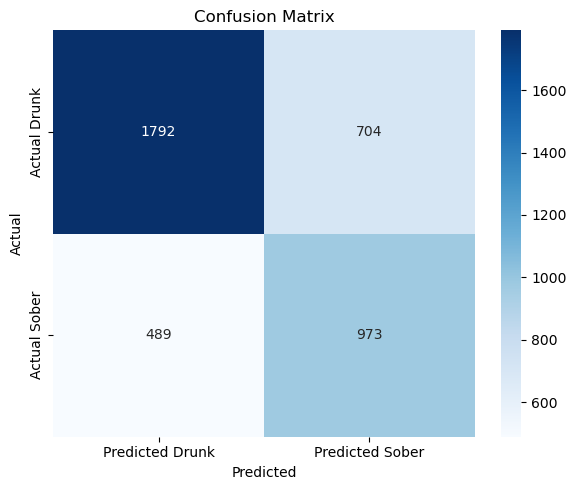

In [17]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from glob import glob
files = glob("../results/HDC/20250326_112132/predictions_20250326_120022.pkl")
assert len(files) > 0, "No prediction files found!"
file_path = files[0]
with open(file_path, "rb") as f:
    predictions = pickle.load(f)


# Get raw test predictions and labels
test_probs = np.array(predictions["test_predictions"])
test_labels = np.array(predictions["test_ground_truth"])

# Use same threshold as during training
threshold = 0.31  # or dynamically extract it from your saved metrics

# Convert to binary predictions
test_binary_preds = (test_probs >= threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(test_labels, test_binary_preds)

# Print it
print("Confusion Matrix:")
print(cm)

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Drunk", "Predicted Sober"],
            yticklabels=["Actual Drunk", "Actual Sober"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [18]:
predictions['test_predictions'][0]

0.11774797737598419

In [19]:
predictions['test_ground_truth'][0]

0.0

In [20]:
# Count class labels
from collections import Counter
test_label_counts = Counter(predictions["test_ground_truth"])
train_label_counts = Counter(predictions["train_ground_truth"])

print("Class counts in TEST set:")
for label, count in sorted(test_label_counts.items()):
    print(f"Label {int(label)}: {count}")

print("\nClass counts in TRAIN set:")
for label, count in sorted(train_label_counts.items()):
    print(f"Label {int(label)}: {count}")

In [21]:
train_label_counts

Counter({0.0: 33036, 1.0: 16576})

In [22]:
test_label_counts

Counter({0.0: 2496, 1.0: 1462})